In [2]:
!pip install ydata_profiling
!pip install prophet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 76.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=9a3fd4e877a9a9c96c46e6a4a7f753cdfc224c44956ca1ebba926155b41930d6
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from ydata_profiling import ProfileReport
#model
from prophet import Prophet
from pandas.tseries.offsets import DateOffset


In [31]:
# Load data
train = pd.read_csv('/content/sample_data/train.csv')    #'id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'
test = pd.read_csv('/content/sample_data/test.csv')      #'id', 'date', 'store_nbr', 'family', 'onpromotion'
stores = pd.read_csv('/content/sample_data/stores.csv')  #'store_nbr', 'city', 'state', 'type', 'cluster'
holidays = pd.read_csv('/content/sample_data/holidays_events.csv') #'date', 'type', 'locale', 'locale_name', 'description', 'transferred'
oil = pd.read_csv('/content/sample_data/oil.csv')                  # 'date', 'dcoilwtico'
transactions = pd.read_csv('/content/sample_data/transactions.csv') #'date', 'store_nbr', 'transactions'

In [32]:
train = train.merge(stores, on='store_nbr', how='left')
train = train.merge(holidays, on='date', how='left')
train = train.merge(oil, on='date', how='left')
train = train.merge(transactions, on=['date','store_nbr'], how='left')

In [13]:
profile = ProfileReport(train,title='Store_sales_analysis')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
train['date'] = pd.to_datetime(train['date']).dt.strftime('%Y/%m/%d')

In [34]:
start=train['date'].min()
end=train['date'].max()
print('Start:',start, ' end',end)

Start: 2013/01/01  end 2017/08/15


In [36]:
train = train.groupby('date')[['sales']].mean().loc[start:end].reset_index()

In [37]:
train.head(10)

date       sales
0  2013/01/01    1.409438
1  2013/01/02  278.390807
2  2013/01/03  202.840197
3  2013/01/04  198.911154
4  2013/01/05  267.873244
5  2013/01/06  291.636028
6  2013/01/07  188.621100
7  2013/01/08  178.646340
8  2013/01/09  169.770375
9  2013/01/10  145.332213

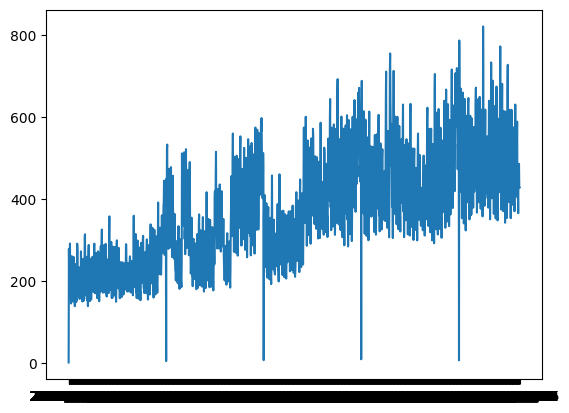

In [39]:
plt.plot(train['date'],train['sales'])
plt.show()

In [40]:
from statsmodels.api import stats
auto_corr =stats.durbin_watson(train[['sales']])

if auto_corr==2:
  print('can''t use TSE, auto correlation exist')
else:
  print('can use TSE')

can use TSE


In [41]:
from prophet import Prophet

prophet_df = train.rename(columns = {'date':'ds','sales':'y'})
model = Prophet(yearly_seasonality=True,h)
model.fit(prophet_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi9nn_v4x/wstbsipe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi9nn_v4x/rmcwakb5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12828', 'data', 'file=/tmp/tmpi9nn_v4x/wstbsipe.json', 'init=/tmp/tmpi9nn_v4x/rmcwakb5.json', 'output', 'file=/tmp/tmpi9nn_v4x/prophet_modelgmo_qupb/prophet_model-20241009133855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:38:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:38:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [42]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

In [45]:
future_data = model.make_future_dataframe(periods=365,freq='D')
future_data

ds
0    2013-01-01
1    2013-01-02
2    2013-01-03
3    2013-01-04
4    2013-01-05
...         ...
2044 2018-08-11
2045 2018-08-12
2046 2018-08-13
2047 2018-08-14
2048 2018-08-15

[2049 rows x 1 columns]

In [46]:
prediction=model.predict(future_data)

In [73]:
prediction.tail(365)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1684 2017-08-16  503.002426  363.184736  519.517583   503.002426   503.002426   
1685 2017-08-17  503.151848  317.748936  467.631536   503.151848   503.151848   
1686 2017-08-18  503.301270  358.936998  508.100887   503.301270   503.301270   
1687 2017-08-19  503.450692  471.728733  618.072758   503.450692   503.450692   
1688 2017-08-20  503.600114  500.256939  660.840286   503.600114   503.600114   
...         ...         ...         ...         ...          ...          ...   
2044 2018-08-11  556.794318  506.881145  675.473577   531.718309   581.452475   
2045 2018-08-12  556.943740  544.360011  701.421732   531.764800   581.717154   
2046 2018-08-13  557.093162  424.348725  596.039919   531.811291   581.981833   
2047 2018-08-14  557.242584  394.656657  559.180212   531.857782   582.246512   
2048 2018-08-15  557.392006  412.219853  573.765375   531.904273   582.511190   

      additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
1684      -62.142428            -62.142428            -62.142428  -24.813747   
1685     -109.758468           -109.758468           -109.758468  -74.006917   
1686      -65.903181            -65.903181            -65.903181  -32.018877   
1687       43.458084             43.458084             43.458084   75.219202   
1688       76.293478             76.293478             76.293478  105.714009   
...              ...                   ...                   ...         ...   
2044       35.257628             35.257628             35.257628   75.219202   
2045       65.477067             65.477067             65.477067  105.714009   
2046      -51.981435            -51.981435            -51.981435  -11.840013   
2047      -77.929593            -77.929593            -77.929593  -38.253658   
2048      -63.662259            -63.662259            -63.662259  -24.813747   

      weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
1684    -24.813747    -24.813747 -37.328682    -37.328682    -37.328682   
1685    -74.006917    -74.006917 -35.751551    -35.751551    -35.751551   
1686    -32.018877    -32.018877 -33.884304    -33.884304    -33.884304   
1687     75.219202     75.219202 -31.761118    -31.761118    -31.761118   
1688    105.714009    105.714009 -29.420531    -29.420531    -29.420531   
...            ...           ...        ...           ...           ...   
2044     75.219202     75.219202 -39.961574    -39.961574    -39.961574   
2045    105.714009    105.714009 -40.236942    -40.236942    -40.236942   
2046    -11.840013    -11.840013 -40.141422    -40.141422    -40.141422   
2047    -38.253658    -38.253658 -39.675935    -39.675935    -39.675935   
2048    -24.813747    -24.813747 -38.848512    -38.848512    -38.848512   

      multiplicative_terms  multiplicative_terms_lower  \
1684                   0.0                         0.0   
1685                   0.0                         0.0   
1686                   0.0                         0.0   
1687                   0.0                         0.0   
1688                   0.0                         0.0   
...                    ...                         ...   
2044                   0.0                         0.0   
2045                   0.0                         0.0   
2046                   0.0                         0.0   
2047                   0.0                         0.0   
2048                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
1684                         0.0  440.859998  
1685                         0.0  393.393380  
1686                         0.0  437.398090  
1687                         0.0  546.908776  
1688                         0.0  579.893592  
...                          ...         ...  
2044                         0.0  592.051947  
2045                         0.0  622.420808  
2046                         0.0  505.111728  
2047       

In [74]:
prediction.to_csv('store_sales_forcasting_result_for365Days')

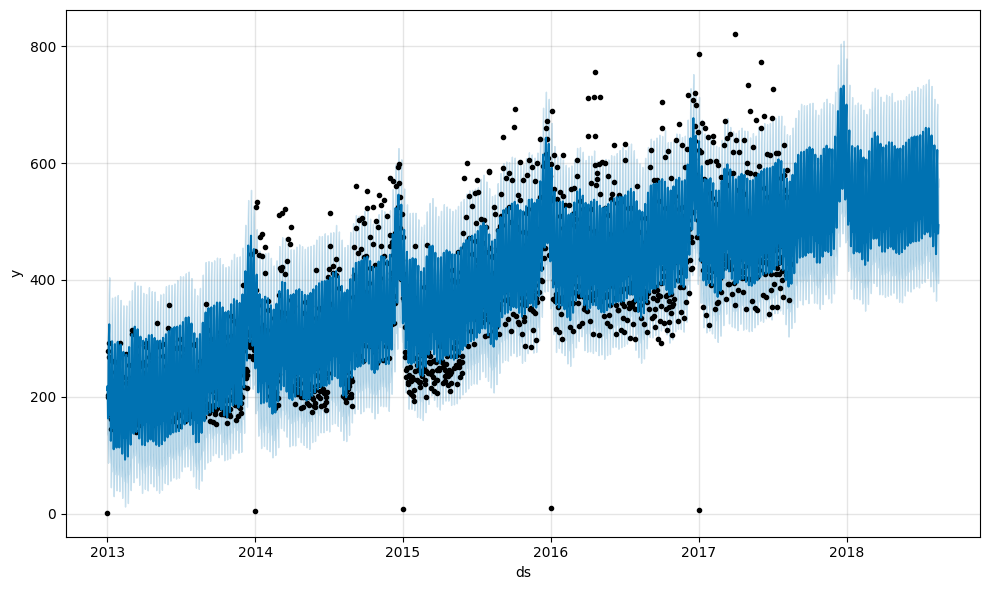

In [49]:
model.plot(prediction)
plt.show()

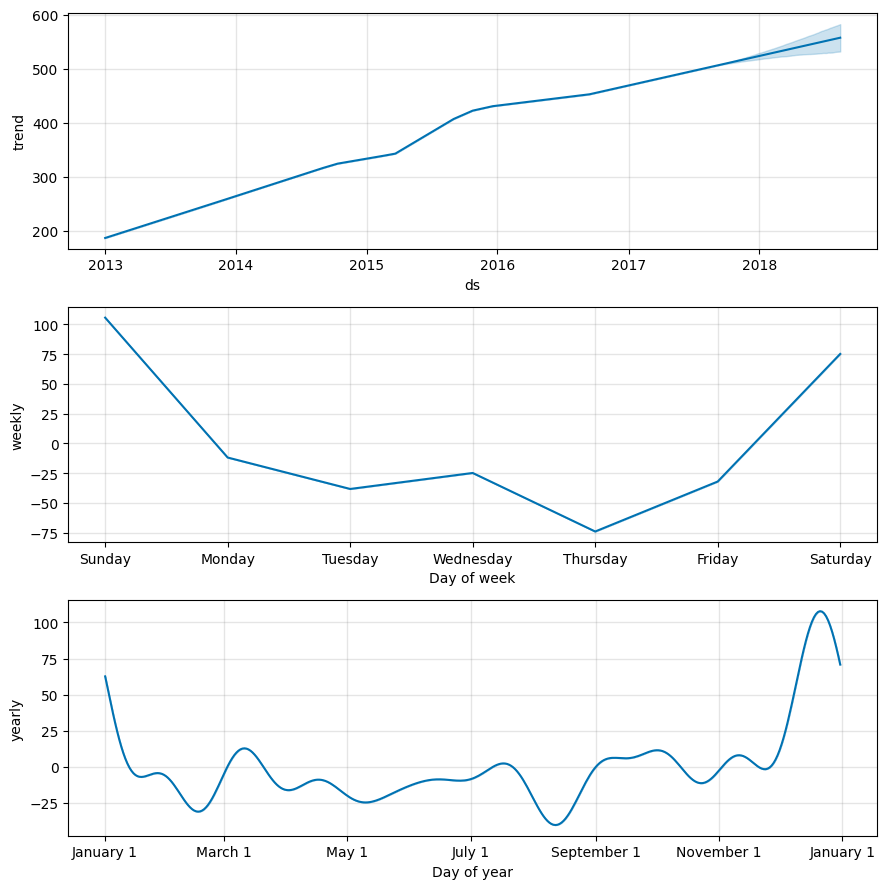

In [51]:
model.plot_components(prediction)
plt.show()

In [56]:
#model evaluation:
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon='365 days', period='1 day')

INFO:prophet:Making 228 forecasts with cutoffs between 2016-01-01 00:00:00 and 2016-08-15 00:00:00


  0%|          | 0/228 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi9nn_v4x/u1a5ntgb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi9nn_v4x/a63bzgmz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23233', 'data', 'file=/tmp/tmpi9nn_v4x/u1a5ntgb.json', 'init=/tmp/tmpi9nn_v4x/a63bzgmz.json', 'output', 'file=/tmp/tmpi9nn_v4x/prophet_modelwhx0ljzc/prophet_model-20241009135400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:54:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:54:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi9nn_v4x/e3n520gu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi9nn_v4x/_fjqn_eb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [71]:
df_cv.tail(10)

ds        yhat  yhat_lower  yhat_upper           y     cutoff
82982 2017-08-06  567.984208  485.225428  651.575604  588.978207 2016-08-15
82983 2017-08-07  457.105979  380.466709  534.466381  447.511203 2016-08-15
82984 2017-08-08  430.986204  348.070368  519.242384  402.786952 2016-08-15
82985 2017-08-09  440.508216  354.829154  516.253008  411.975126 2016-08-15
82986 2017-08-10  397.031117  323.545308  487.285899  365.536988 2016-08-15
82987 2017-08-11  430.619675  343.392404  513.318693  463.733851 2016-08-15
82988 2017-08-12  535.152380  450.256856  615.587756  444.798280 2016-08-15
82989 2017-08-13  564.677919  484.961178  651.445602  485.768618 2016-08-15
82990 2017-08-14  456.218092  373.415543  537.084106  427.004717 2016-08-15
82991 2017-08-15  432.578611  350.557257  512.781931  427.980884 2016-08-15

In [57]:
score=performance_metrics(df_cv)

In [62]:
score.head(10)

horizon          mse       rmse        mae      mape     mdape     smape  \
0 37 days  5863.375201  76.572679  61.137064  0.146250  0.122938  0.137736   
1 38 days  5915.103350  76.909709  61.465045  0.147153  0.124204  0.138454   
2 39 days  5964.395066  77.229496  61.780814  0.148014  0.124880  0.139136   
3 40 days  6012.710749  77.541671  62.097396  0.148864  0.125545  0.139808   
4 41 days  6059.305516  77.841541  62.402826  0.149686  0.126291  0.140454   
5 42 days  6105.867859  78.140053  62.709609  0.150519  0.126792  0.141108   
6 43 days  6154.156941  78.448435  63.030227  0.151396  0.127678  0.141798   
7 44 days  6203.345035  78.761317  63.361382  0.152302  0.128943  0.142516   
8 45 days  6254.117024  79.082976  63.704518  0.153249  0.130126  0.143270   
9 46 days  6305.175744  79.405137  64.052273  0.154197  0.132249  0.144028   

   coverage  
0  0.651747  
1  0.648036  
2  0.644494  
3  0.641289  
4  0.637915  
5  0.635289  
6  0.632059  
7  0.628156  
8  0.625336  
9  0.622300

In [69]:
score.sort_values(by=['mape'])

horizon           mse        rmse        mae      mape     mdape  \
0    37 days   5863.375201   76.572679  61.137064  0.146250  0.122938   
1    38 days   5915.103350   76.909709  61.465045  0.147153  0.124204   
2    39 days   5964.395066   77.229496  61.780814  0.148014  0.124880   
3    40 days   6012.710749   77.541671  62.097396  0.148864  0.125545   
4    41 days   6059.305516   77.841541  62.402826  0.149686  0.126291   
..       ...           ...         ...        ...       ...       ...   
201 238 days  13937.405465  118.056789  96.964246  0.688650  0.203392   
202 239 days  13940.325109  118.069154  96.905146  0.688652  0.202770   
200 237 days  13934.495233  118.044463  97.017232  0.688659  0.203816   
203 240 days  13942.667898  118.079075  96.843305  0.688669  0.202770   
204 241 days  13943.148905  118.081112  96.778401  0.688675  0.202813   

        smape  coverage  
0    0.137736  0.651747  
1    0.138454  0.648036  
2    0.139136  0.644494  
3    0.139808  0.641289  
4    0.140454  0.637915  
..        ...       ...  
201  0.204142  0.393339  
202  0.203927  0.393984  
200  0.204352  0.392027  
203  0.203715  0.394399  
204  0.203501  0.394919  

[329 rows x 8 columns]

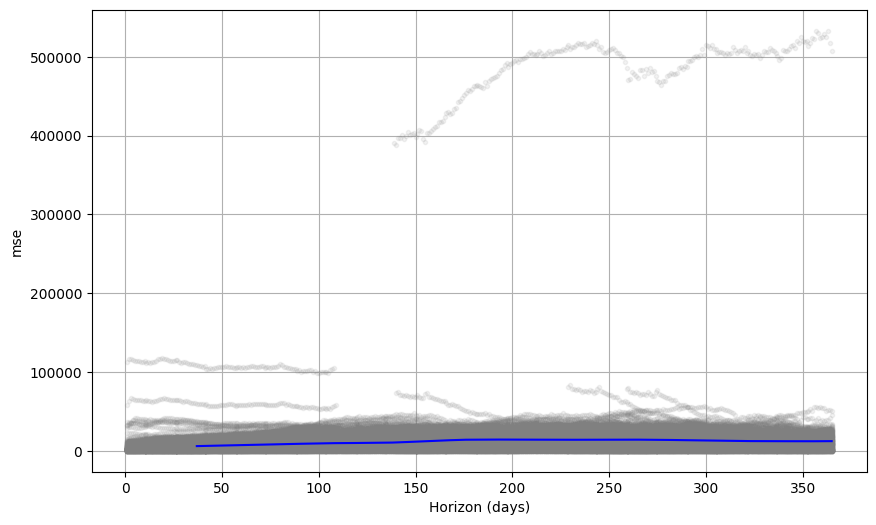

In [65]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mse')
plt.show()